### Import libraries

In [30]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
import re
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
from sklearn.tree import DecisionTreeClassifier

### Data cleaning

In [31]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

[nltk_data] Downloading package punkt to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Wei Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
# Load data
books = {'Action' : ['The Maze Runner', 'Dune', 'Jurassic Park', 'Ready Player One', 'The Hunger Games'],
           'Comedy' : ['Confed of Dunces', 'Catch-22', 'Good Omens', 'The Catcher in the Rye', 'The Idiot'],
           'Fantasy' : ['Eragon', 'Narnia', 'The Hobbit', 'The Last Wish', 'The Royal Ranger'],
           'Horror' : ['Dracula', 'Frankenstein', 'THe Exorcist', 'The Housemaid', 'The Shining'],
           'Mystery' : ['Gone Girl', 'Rebecca', 'The Maid', 'The Secret History', 'Devil in the White City']}

books_df = pd.DataFrame()

for genre, genre_books in books.items():
    for book in genre_books:
        excel_file_path = os.path.join(f"labelled_data/{genre.lower()}/{genre}_{book}_analyzed_reviews.xlsx")
        df = pd.read_excel(excel_file_path)
        books_df = pd.concat([books_df, df], ignore_index=True)

books_df.head()

,post_id,comment_text,author,created_utc,sentiment,manual_label,user_sentiment,Unnamed: 6,Manual Label
0,iz0gss,I feel like the much much better version of th...,Waker_of_Winds2003,2020-09-24 17:34:24,0,0.0,NaN,NaN,NaN
1,iz0gss,Totally agree. Ender's game is one of the best...,Atreides16,2020-09-24 17:42:34,1,0.0,NaN,NaN,NaN
2,k51srz,The Maze Runner trilogy left me wholly dissati...,No-Seaweed-4456,2020-12-02 18:51:24,0,0.0,NaN,NaN,NaN
3,k51srz,the book itself was good and all and I just fi...,patric5,2020-12-02 22:04:17,1,1.0,NaN,NaN,NaN
4,k51srz,"James Dashner is an idea guy, but fails misera...",NefarioussNess,2020-12-02 18:57:47,0,0.0,NaN,NaN,NaN


In [33]:
# Check that sentimt is of integer
books_df.dtypes

post_id            object
comment_text       object
author             object
created_utc        object
sentiment           int64
manual_label      float64
user_sentiment    float64
Unnamed: 6        float64
Manual Label      float64
dtype: object

In [34]:
comment_df = books_df[['comment_text', 'sentiment']]

In [35]:
# drop 2 and 3
comment_df = comment_df[comment_df.sentiment != 2]
comment_df = comment_df[comment_df.sentiment != 3]
comment_df['sentiment'].unique()

array([0, 1], dtype=int64)

In [36]:
def data_cleaning(x):
    x = str(x)
    pattern = '[^a-zA-Z0-9\ ]'
    x = re.sub(pattern,'',x)
    x = x.lower()
    x = x.strip()
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    x = re.sub(r'(.)\1+', r'\1\1', x)
    # Remove - & '
    x = re.sub(r'(-|\')', ' ', x)
    return x

In [37]:
def remove_links_funny_words(x):
    x = re.sub('(https?://[\S]+)', ' URL ', str(x))
    x = x.replace("xmass", "christmas")
    x = x.replace("...", " ")
    x = x.replace("'ll", "will")
    x = x.replace("tewwible", "terrible")
    x = x.replace("frekking", "freaking")
    return x

In [38]:
comment_df = comment_df[comment_df['comment_text'] != '']
comment_df['content'] = comment_df['comment_text'].apply(remove_links_funny_words).apply(data_cleaning)
comment_df.head()

,comment_text,sentiment,content
0,I feel like the much much better version of th...,0,i feel like the much much better version of th...
1,Totally agree. Ender's game is one of the best...,1,totally agree enders game is one of the best s...
2,The Maze Runner trilogy left me wholly dissati...,0,the maze runner trilogy left me wholly dissati...
3,the book itself was good and all and I just fi...,1,the book itself was good and all and i just fi...
4,"James Dashner is an idea guy, but fails misera...",0,james dashner is an idea guy but fails miserab...


In [39]:
# deal with empty values
comment_df['comment_text'] = comment_df['comment_text'].fillna('').apply(str)
comment_df.head()

,comment_text,sentiment,content
0,I feel like the much much better version of th...,0,i feel like the much much better version of th...
1,Totally agree. Ender's game is one of the best...,1,totally agree enders game is one of the best s...
2,The Maze Runner trilogy left me wholly dissati...,0,the maze runner trilogy left me wholly dissati...
3,the book itself was good and all and I just fi...,1,the book itself was good and all and i just fi...
4,"James Dashner is an idea guy, but fails misera...",0,james dashner is an idea guy but fails miserab...


In [40]:
# Stemming
def word_pre(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    store = ''

    for i in x:
        store += stemmer.stem(i) + ' '

    return store

# Stopwords
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d"]
stop = set(stop + additional_stopwords)
def remove_stop(x):
    x = word_tokenize(x)
    store = ''

    for i in x:
        if i not in stop:
            store += i + ' '

    return store

def lemmatize(text):
  store = ''
  tokens = word_tokenize(text)
  lemma_function = WordNetLemmatizer()
  for token, tag in pos_tag(tokens):
    store += lemma_function.lemmatize(token, tag_map[tag[0]]) + ' '
  return str(store)

In [41]:
comment_df['comment_cleaned'] = comment_df['comment_text'].apply(remove_stop)

### Split data

In [42]:
x_train, x_test, y_train, y_test = train_test_split(comment_df[['comment_cleaned']],
                                                    comment_df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=0)

In [43]:
vectorizer = CountVectorizer(ngram_range=(1,2))
comment_matrix = vectorizer.fit_transform(x_train['comment_cleaned'])

### Decision Tree

In [44]:
decision_tree=DecisionTreeClassifier(criterion='gini',splitter='best',max_features='sqrt')
comment_classifier = decision_tree.fit(comment_matrix, y_train)

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = comment_classifier.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)
confuse

array([[ 168,  428],
       [ 264, 1537]], dtype=int64)

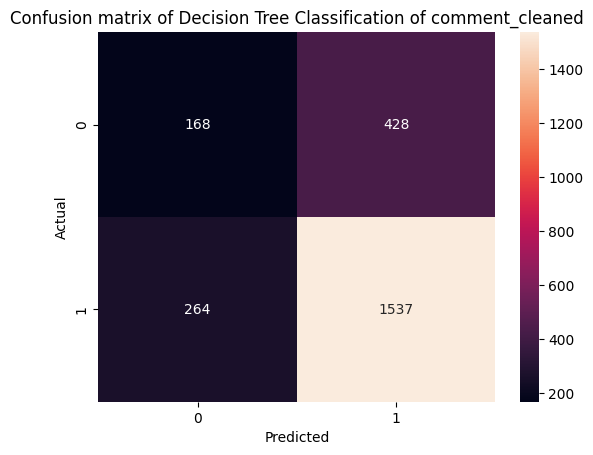

In [45]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
dt_F1_score = metrics.f1_score(y_test, result)
dt_average_precision = metrics.average_precision_score(y_test, result)
dt_precision_score= metrics.precision_score(y_test, result)
dt_recall_score = metrics.recall_score(y_test, result)
dt_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(dt_F1_score))
print('Precision score: {0:0.3f}'.format(dt_precision_score))
print('Recall score: {0:0.3f}'.format(dt_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(dt_average_precision))
print('Accuracy score: {0:0.3f}'.format(dt_accuracy))

F1 score: 0.816
Precision score: 0.782
Recall score: 0.853
Average precision-recall score: 0.778
Accuracy score: 0.711


### Enhanced Decision Tree - Grid Search [3-folds]

In [47]:
param_grid = { 
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv= 3)
grid_search.fit(test_vector, y_test)
grid_search.best_params_

C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

{'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}

In [48]:
decision_tree=DecisionTreeClassifier(criterion='entropy',splitter='random',max_features='sqrt')
comment_classifier = decision_tree.fit(comment_matrix, y_train)

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = comment_classifier.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)
confuse

array([[ 182,  414],
       [ 262, 1539]], dtype=int64)

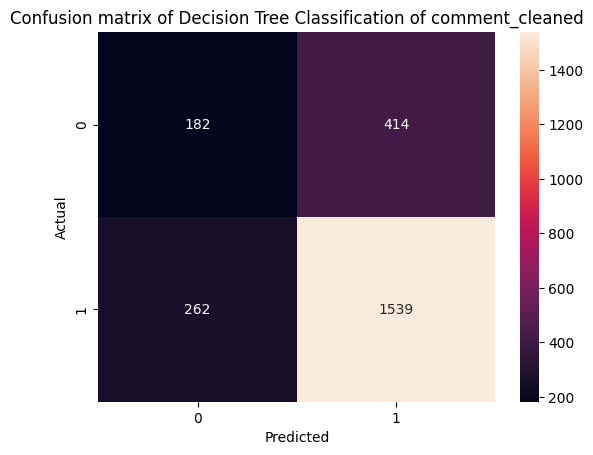

In [49]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
dt_3fold_F1_score = metrics.f1_score(y_test, result)
dt_3fold_average_precision = metrics.average_precision_score(y_test, result)
dt_3fold_precision_score= metrics.precision_score(y_test, result)
dt_3fold_recall_score = metrics.recall_score(y_test, result)
dt_3fold_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(dt_3fold_F1_score))
print('Precision score: {0:0.3f}'.format(dt_3fold_precision_score))
print('Recall score: {0:0.3f}'.format(dt_3fold_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(dt_3fold_average_precision))
print('Accuracy score: {0:0.3f}'.format(dt_3fold_accuracy))

F1 score: 0.820
Precision score: 0.788
Recall score: 0.855
Average precision-recall score: 0.783
Accuracy score: 0.718


### Enhanced Decision Tree - Grid Search [5-folds]

In [51]:
param_grid = { 
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv= 5)
grid_search.fit(test_vector, y_test)
grid_search.best_params_

C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

{'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}

In [52]:
decision_tree=DecisionTreeClassifier(criterion='entropy',splitter='random',max_features='sqrt')
comment_classifier = decision_tree.fit(comment_matrix, y_train)

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = comment_classifier.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)
confuse

array([[ 184,  412],
       [ 291, 1510]], dtype=int64)

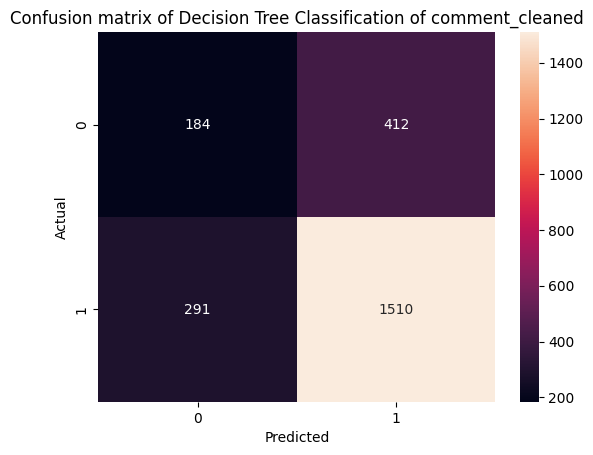

In [53]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [54]:
dt_5fold_F1_score = metrics.f1_score(y_test, result)
dt_5fold_average_precision = metrics.average_precision_score(y_test, result)
dt_5fold_precision_score= metrics.precision_score(y_test, result)
dt_5fold_recall_score = metrics.recall_score(y_test, result)
dt_5fold_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(dt_5fold_F1_score))
print('Precision score: {0:0.3f}'.format(dt_5fold_precision_score))
print('Recall score: {0:0.3f}'.format(dt_5fold_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(dt_5fold_average_precision))
print('Accuracy score: {0:0.3f}'.format(dt_5fold_accuracy))

F1 score: 0.811
Precision score: 0.786
Recall score: 0.838
Average precision-recall score: 0.780
Accuracy score: 0.707


### Evaluation

In [55]:
print("Decison Tree")
print('Accuracy score: {0:0.3f}'.format(dt_accuracy))
print()
print("Decision Tree - Grid Search - 3-folds")
print('Accuracy score: {0:0.3f}'.format(dt_3fold_accuracy))
print()
print("DEcision Tree - Grid Search - 5-folds")
print('Accuracy score: {0:0.3f}'.format(dt_5fold_accuracy))

Decison Tree
Accuracy score: 0.711

Decision Tree - Grid Search - 3-folds
Accuracy score: 0.718

DEcision Tree - Grid Search - 5-folds
Accuracy score: 0.707
